# packages

In [3]:
import random
import warnings
warnings.filterwarnings('ignore')
from operator import itemgetter
import numpy as np
import pandas as pd
import math
import time
import matplotlib.pyplot as plt
% matplotlib inline

# The Genetic Algorithm

In [5]:
# Step 0: generate the first population
def generateFirstPop(sizePopulation, numPay, low_bound, up_bound):
    pop_matrix = (sizePopulation, numPay)
    initial_populaiton = np.random.uniform(low = low_bound, high = up_bound, size = pop_matrix)
    initial_populaiton = pd.DataFrame(initial_populaiton)
    return initial_populaiton

# Step 1: calculate fitness function
def computeFitnessVal(populationX, numPay, prior, finPrior, maxDeduct, budget,
                      cost, a, b, MIRR):
    """
    Input:
    (1) a new generation (population)
    (2) number of payment
    (3) priority vector
    (4) financial consideration
    (5) maximum deduction ratio
    (6) budget
    (7) cost vector
    (8) performance function parameters: a and b
    (9) MIRR 

    Return: 
    (1) sorted population
    (2) sorted fitness value
    (3) sorted performance
    (4) sorted overall_performance, and 
    (5) sorted total cost
    """

    sort_pop = np.empty((populationX.shape[0], populationX.shape[1]))
    fit_pool = {}
    # other_pool = {}
    sort_value = []
    sort_performance = []
    sort_over_perf = []
    sort_cost = []
    
    for i in range(len(populationX)):
        fit_pool[i] = fitness_UL(populationX.iloc[i,:], numPay, prior,
                                 finPrior, maxDeduct, budget, cost, a, b, MIRR)
    fit_pool = pd.DataFrame(fit_pool)
    sort_fit = sorted(fit_pool.iloc[0,:].items(), key=itemgetter(1), reverse = True)
    
    for j in range(len(populationX)):
        sort_idx = sort_fit[j][0]
        sort_value.append(sort_fit[j][1])
        sort_performance.append(fit_pool.iloc[1, sort_idx])
        sort_over_perf.append(fit_pool.iloc[2, sort_idx])
        sort_cost.append(fit_pool.iloc[3, sort_idx])
        sort_pop[j] = (populationX.iloc[sort_idx,:])
    return sort_pop, sort_value, sort_performance, sort_over_perf, sort_cost

# Step 2: the basis of the genetic algorithm functions for generating next population
# 2.1 select the parents (breeders) from the current population
def selectFromPopulation(populationSorted, numBestSample, numLuckSample):
    """
    (the selection strategy can be modified by other methods)
    
    Return:
    (1) parents for generating the next population / generation
    """
    nextParents = []
    for i in range(numBestSample):
        nextParents.append(populationSorted[i][:]) # add a top rank individual; [0] need to be adjusted
    for i in range(numLuckSample):
        nextParents.append(random.choice(populationSorted)[:]) # add a lucky individual
    random.shuffle(nextParents)
    nextParents = pd.DataFrame(nextParents)
    return nextParents

# 2.2 mating parents (generating children)
def crossover(parents, sizepopulation, numPay):
    offspring = np.empty([sizepopulation, numPay])
    cross_point = np.uint8(numPay / 2) # where to get the combination (may change by another way)

    for k in range(sizepopulation):
        # index of the first parent to mate
        parent1_idx = k % parents.shape[0]
        # index of the second parent to mate
        parent2_idx = (k + 1) % parents.shape[0]
        parents_array = parents.values
        offspring[k, 0:cross_point] = parents_array[parent1_idx, 0:cross_point]
        offspring[k, cross_point:] = parents_array[parent2_idx, cross_point:]
    return offspring

# 2.3 mutate the whole populaiton
def mutatePopulation(population, mutationProb, negRange, posRange):
    """
    :return:
    (1) the next generation
    """
    for i in range(population.shape[0]):
            for j in range(population.shape[1]):
                if random.random() * 100 < mutationProb: # possibility to mutate
                    population[i][j] = population[i][j] + np.random.uniform(negRange, posRange, 1)
    return population

# Step 3: generate the next payment population (x)
def nextGeneration_UL(preGenerationX, numPay, prior, finPrior, maxDeduct, cost,
                      budget, numBestSample, numLuckSample, sizePopulation,
                      mutationProb, negRange, posRange, a, b, MIRR):
    """
    Return:
    (1) the next generation of x (payment)
    (2) Current fitness value
    (3) Current performance
    (4) Current overall performance
    (5) Current cost
    """
    all = computeFitnessVal(preGenerationX, numPay, prior, finPrior, maxDeduct,
                                   budget, cost, a, b, MIRR)
    popXSorted = all[0]
    currentValue = all[1]
    currentPerf = all[2]
    currentOverallPerf = all[3]
    currentCost = all[4]
    nextBreeders = selectFromPopulation(popXSorted, numBestSample, numLuckSample) # generate the parents
    nextPopulation = crossover(nextBreeders, sizePopulation, numPay)
    next_generation_x = mutatePopulation(nextPopulation, mutationProb, negRange, posRange)
    next_generation_x = pd.DataFrame(next_generation_x)
    return next_generation_x, currentValue, currentPerf, currentOverallPerf, currentCost

# Step 4: the main interation for the genetic algorithm
def multipleGeneration(number_of_generation, sizePopulation, numPay, lowBoundPay, upBoundPay,
                       prior, finPrior, cost, maxDeduct, budget, numBestSample, numLuckSample,
                       mutationProb, negRange, posRange, a, b, MIRR):
    """
    Return:
    (1) the whole generations of x (payment)
    (2) the whole generations of fitness value
    (3) the whole generations of performance
    (4) the whole generations of overall performance
    (5) the whole generations of cost
    """
    historic_all = []
    historic_x = []
    historic_x.append(generateFirstPop(sizePopulation, numPay, lowBoundPay, upBoundPay))
    historic_value = []
    historic_perf = []
    historic_overallperf = []
    historic_cost = []
    for i in range (number_of_generation):
        historic_all.append(nextGeneration_UL(historic_x[i], numPay, prior, finPrior, maxDeduct,
                                            cost, budget, numBestSample, numLuckSample,
                                            sizePopulation, mutationProb, negRange, posRange,
                                            a, b, MIRR))
        historic_x.append(historic_all[i][0])
        historic_value.append(historic_all[i][1])
        historic_perf.append(historic_all[i][2])
        historic_overallperf.append(historic_all[i][3])
        historic_cost.append(historic_all[i][4])

    return historic_x, historic_value, historic_perf, historic_overallperf, historic_cost

# Objective Function (Eq. 8-11)

In [6]:
def fitness_UL(x, numPay, prior, finPrior, maxDeduct, budget, cost, a, b, MIRR):
    """
    Return:
    (1) fitness value
    (2) performance
    (3) overall performance
    (4) total project price
    """
    max_obj = 0
    norm = 100 / budget * finPrior
    performance = []
    perf_norand = []
    overall_perf = 0
    profit = 0
    total_cost = 0
    expense = []
    # deduction = []
    for i in range(numPay):
        performance = performance + [100 * (2 * cost[i] / a) / (x[i] - pow(x[i], 0.5) * pow(x[i] - 4 * cost[i] / a, 0.5))
                                  + np.random.normal(3.5, 1.7)]
        perf_norand = perf_norand + [100 * (2 * cost[i] / a) / (x[i] - pow(x[i], 0.5) * pow(x[i] - 4 * cost[i] / a, 0.5))]

        if performance[i] > 100: performance[i] = 100

        max_obj = max_obj + prior[i] * performance[i] - (x[i] * norm)
        overall_perf = overall_perf + prior[i] * performance[i]

        # constraints
        if performance[i] < 50:
            max_obj = 0.1*max_obj
        if x[i] > budget or \
                x[i] < 0 or \
                x[i] - 4 * cost[i] / (a * maxDeduct) < 0:
                    max_obj = -999

        expense = expense + [(cost[i] * (b - math.log((x[i] - pow(x[i], 0.5) * pow(x[i] - 4 * cost[i] / a, 0.5)) / (
                                                     2 * cost[i] / a) - 1)) / a)]
        profit = profit + (x[i] - ((100 - perf_norand[i]) / 100) * x[i] - expense[i])
        total_cost = total_cost + (x[i] - ((100 - perf_norand[i]) / 100) * x[i])

    if sum(x) > budget or profit < 0: max_obj = -999
    elif profit/sum(expense) < MIRR: max_obj = max_obj - 100 * (1 - (profit/sum(expense))/MIRR)

    fitnessVal = max_obj
    return fitnessVal, performance, overall_perf, total_cost

# Visualization

In [7]:
# visualization
"1. The value of the overall fitness function" \
"2. The overall performance" \
"3. The total cost" \
"4. The revenue"

# 0) record the best value for each iteration (generation)
def getBestFitnessValueFromPopulationPay (populationX, numPay, prior, finPrior,
                                          maxDeduct, budget, cost, a, b):
    return computeFitnessVal(populationX, numPay, prior, finPrior, maxDeduct, budget, cost, a, b)[1][0]


def getListBestFitvalueFromHistoriquePay (historic_x, numPay, prior, finPrior,
                                          maxDeduct, budget, cost, a, b):
    bestFitness_x = []
    for i in range(len(historic_x)):
        bestFitness_x.append(getBestFitnessValueFromPopulationPay(historic_x[i], numPay, prior, finPrior,
                                                                  maxDeduct, budget, cost, a, b))
    return bestFitness_x

# 1) visualization of each payment amount
def visualPayment(history):
    labels = ['payment 1', 'payment 2', 'payment 3', 'payment 4', 'payment 5']
    all_data = history[0][len(history[1])].T
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
    axes.set_title('The Suggested Payment Mechanism')
    bplot1 = axes.boxplot(all_data, vert=True, patch_artist=True, labels=labels)

    colors = ['darkblue', 'darkgreen', 'black', 'darkred', 'purple']

    for patch, color in zip(bplot1['boxes'], colors):
        patch.set_facecolor(color)
    plt.show()
    
# 2) visualization of the fitness value
def evolutionBestFitness(history):
    plt.axis([0, len(history[1]), -100, 100])
    plt.title("Fitness Value")
    evolutionFitness = []
    for i in range(len(history[1])):
        evolutionFitness.append(history[1][i][0])
    plt.plot(evolutionFitness)
    plt.ylabel('fitness best individual')
    plt.xlabel('generation')
    plt.show()

# 3) visualization of the overall performance
def evolutionBestPerf(history):
    plt.axis([0, len(history[3]), 0, 100])
    plt.title("overall performance")
    evoluaitonPerf = []
    for i in range(len(history[3])):
        evoluaitonPerf.append(history[3][i][0])
    plt.plot(evoluaitonPerf)
    plt.ylabel('overall performance')
    plt.xlabel('generation')
    plt.show()

# 4) visualization of the government's total cost
def evolutionTotalCost(history, budget):
    plt.axis([0, len(history[4]), 0, budget])
    plt.title("total cost")
    evoluaitonCost = []
    for i in range(len(history[4])):
        evoluaitonCost.append(history[4][i][0])
    plt.plot(evoluaitonCost)
    plt.ylabel('Cost')
    plt.xlabel('generation')
    plt.show()

# 5) visualization of each performance
def getEachPerf(history):
    eachPerf = []
    for i in range(len(history[2])):
        eachPerf.append(history[2][i][0])
    eachPerf = pd.DataFrame(eachPerf)
    return eachPerf

def evolutionPerf(history, eachPerf):
    plt.figure(num=6, figsize=(16, 8))
    # plt.title("Each Performance")
    # performance 1
    plt.subplot(231)
    plt.axis([0, len(history[2]), 50, 110])
    plt.title('Performance 1')
    plt.plot(eachPerf.iloc[:, 0], 'r')
    # performance 2
    plt.subplot(232)
    plt.axis([0, len(history[2]), 50, 110])
    plt.title('Performance 2')
    plt.plot(eachPerf.iloc[:, 1], 'b')
    # performance 3
    plt.subplot(233)
    plt.axis([0, len(history[2]), 50, 110])
    plt.title('Performance 3')
    plt.plot(eachPerf.iloc[:, 2], 'g')
    # performance 4
    plt.subplot(234)
    plt.axis([0, len(history[2]), 50, 110])
    plt.title('Performance 4')
    plt.plot(eachPerf.iloc[:, 3], 'y')
    # performance 5
    plt.subplot(235)
    plt.axis([0, len(history[2]), 50, 110])
    plt.title('Performance 5')
    plt.plot(eachPerf.iloc[:, 4], 'black')
    plt.show()

    # other way
def evolutionPerf2(history, eachPerf, colorname):
    for i,color in enumerate(colorname):
        plt.subplot(231+i)
        plt.axis([0, len(history[2]), 50, 110])
        plt.title('Performance %d' % (1+i))
        plt.plot(eachPerf.iloc[:, i], color)
    plt.show()

# 6) visualization of the contractor's revenue
def fitness_LL(x, numPay, performance, a, b, cost, maxDeduct):
    total_revenue = 0
    total_expense = 0
    for i in range(numPay):
        total_revenue = total_revenue + (x[i] - ((100-performance[i])/100)*x[i] - cost[i]*
                                         (b-math.log((x[i] - pow(x[i], 0.5) * pow(x[i] - 4 * cost[i] / a, 0.5)) / (2 * cost[i] / a) - 1))/a)
        total_expense = total_expense + (cost[i] * (b - math.log((x[i] - pow(x[i], 0.5) * pow(x[i] - 4 * cost[i] / a, 0.5)) / (
                                          2 * cost[i] / a) - 1)) / a)
    return total_revenue, total_expense

def evolutionRevenue(history, numPay, a, b, cost, maxDeduct):
    revenue = []
    for j in range(len(history[2])):
        revenue.append(
            fitness_LL(history[0][j].iloc[0,:], numPay, history[2][j][0], a, b, cost, maxDeduct)[0]
        )
    plt.axis([0, len(history[2]), -200, 500])
    plt.title('Revenue')
    plt.plot(revenue, 'y')
    plt.ylabel('$')
    plt.xlabel('generation')
    plt.show()

def evolutionExpense(history, numPay, a, b, cost, maxDeduct):
    revenue = []
    for j in range(len(history[2])):
        revenue.append(
            fitness_LL(history[0][j].iloc[0,:], numPay, history[2][j][0], a, b, cost, maxDeduct)[1]
        )
    plt.axis([0, len(history[2]), 0, 2000])
    plt.title('Expense')
    plt.plot(revenue, 'y')
    plt.ylabel('$')
    plt.xlabel('generation')
    plt.show()

# Advanced Visualization

In [8]:
# 1) visualize total payment and overall performance in the same figure
def evolutionPriceCost(history, budget):
    evoluaitonPerf = []
    evoluaitonCost = []
    for i in range(len(history[3])):
        evoluaitonPerf.append(history[3][i][0])
        evoluaitonCost.append(history[4][i][0])
    fig, ax1 = plt.subplots()
    plt.title("Project Total Price (Payment) vs. Overall Performance")
    plt.axis([0, len(history[3]), 0, 100])
    ax1.plot(evoluaitonPerf, color = 'blue')
    ax1.set_ylabel(r'Overall Performance', color = 'blue')
    for label in ax1.get_yticklabels():
        label.set_color("blue")
    ax1.annotate('Performance', xy=(200, 92), xytext=(300, 80),
                  arrowprops=dict(facecolor='black', shrink=0.05, width = 1, headwidth = 5, color = 'b'),
                  color = 'b', horizontalalignment='left',verticalalignment='bottom')        

    ax2 = ax1.twinx()
    plt.axis([0, len(history[4]), 0, budget])
    ax2.plot(evoluaitonCost, color = 'darkgreen')
    ax2.set_ylabel(r'Project Total Price / Payment', color = 'darkgreen')
    for label in ax2.get_yticklabels():
        label.set_color("darkgreen")
    ax2.annotate('Total Payment', xy=(500, 1250), xytext=(300, 1000),
                  arrowprops=dict(facecolor='black', shrink=0.05, width = 1, headwidth = 5, color = 'darkgreen'),
                  color = 'darkgreen', horizontalalignment='left',verticalalignment='bottom')         
        
# 2) visualize contractor's revenue and cost in the same figure
def evolutionProfitExpense(history, numPay, a, b, cost, maxDeduct):
    revenue = []
    expense = []
    for j in range(len(history[2])):
        revenue.append(
            fitness_LL(history[0][j].iloc[0,:], numPay, history[2][j][0], a, b, cost, maxDeduct)[0]
        )
        expense.append(
            fitness_LL(history[0][j].iloc[0,:], numPay, history[2][j][0], a, b, cost, maxDeduct)[1]
        )
    fig, ax1 = plt.subplots()
    plt.title("Contractor's Profit vs. Cost")
    plt.axis([0, len(history[2]), 0, 1000])
    ax1.plot(revenue, color = 'darkblue')
    ax1.set_ylabel(r"Contractor's Profit", color = 'darkblue')
    for label in ax1.get_yticklabels():
        label.set_color("darkblue")
    ax1.annotate('Profit', xy=(500, 250), xytext=(300, 100),
                  arrowprops=dict(facecolor='black', shrink=0.05, width = 1, headwidth = 5, color = 'darkblue'),
                  color = 'darkblue', horizontalalignment='left',verticalalignment='bottom')           

    ax2 = ax1.twinx()
    plt.axis([0, len(history[2]), 0, 2000])
    ax2.plot(expense, color = 'darkgreen')
    ax2.set_ylabel(r'Total Expense', color = 'darkgreen')
    for label in ax2.get_yticklabels():
        label.set_color("darkgreen")
    ax2.annotate('Expense', xy=(300, 1100), xytext=(500, 1400),
                  arrowprops=dict(facecolor='black', shrink=0.05, width = 1, headwidth = 5, color = 'darkgreen'),
                  color = 'darkgreen', horizontalalignment='left',verticalalignment='bottom')         
        
        
# 3) visualize the evolution of each payment
def evolutionEachPayment(history):
    payment1 = []
    payment2 = []
    payment3 = []
    payment4 = []
    payment5 = []
    for i in range(len(history[0])):
        payment1.append(history[0][i].iloc[0,0])
        payment2.append(history[0][i].iloc[0,1])
        payment3.append(history[0][i].iloc[0,2])
        payment4.append(history[0][i].iloc[0,3])
        payment5.append(history[0][i].iloc[0,4])

    fig, ax1 = plt.subplots()
    plt.title("The Evolution of Each Payment")
    plt.xlabel('Generation')
    plt.axis([0, len(history[0]), 0, 1000])

    ax1.plot(payment1, color = 'darkblue')
    ax1.set_ylabel(r"Payment ($M)")
    ax2 = ax1.twinx()
    ax2.plot(payment2, color = 'darkgreen')
    ax2.get_yaxis().set_visible(False)
    ax3 = ax1.twinx()
    ax3.plot(payment3, color='black')
    ax3.get_yaxis().set_visible(False)
    ax4 = ax1.twinx()
    ax4.plot(payment4, color='darkred')
    ax4.get_yaxis().set_visible(False)
    ax5 = ax1.twinx()
    ax5.plot(payment5, color='purple')
    ax5.get_yaxis().set_visible(False)

In [9]:
# 4) performance and each payment
def evolutionEachPerfPay(history, eachPerf):
    payment1 = []
    payment2 = []
    payment3 = []
    payment4 = []
    payment5 = []
    for i in range(len(history[0])):
        payment1.append(history[0][i].iloc[0,0])
        payment2.append(history[0][i].iloc[0,1])
        payment3.append(history[0][i].iloc[0,2])
        payment4.append(history[0][i].iloc[0,3])
        payment5.append(history[0][i].iloc[0,4])

    plt.figure(num=6, figsize=(8, 4))
    # plt.title("Each Performance")
    # performance 1
    # plt.subplot(231)
    fig, ax1 = plt.subplots()
    plt.axis([0, len(history[2]), 50, 110])
    plt.xlabel('Generation')
    plt.title('(a) Goal 1')
    ax1.plot(eachPerf.iloc[:, 0], 'r')
    ax1.set_ylabel(r'Performance', color = 'r')
    for label in ax1.get_yticklabels():
        label.set_color("r")
    ax1.annotate('Performance', xy=(150, 98), xytext=(200, 105),
                  arrowprops=dict(facecolor='black', shrink=0.05, width = 1, headwidth = 5, color = 'r'),
                  color = 'r', horizontalalignment='left',verticalalignment='bottom')

    ax2 = ax1.twinx()
    plt.axis([0, len(history[0]), 0, 1000])
    ax2.plot(payment1, color='b')
    ax2.set_ylabel(r'Payment ($M)', color='b')
    for label in ax2.get_yticklabels():
        label.set_color("b")
    ax2.annotate('Payment', xy=(150, 600), xytext=(250, 450),
                  arrowprops=dict(facecolor='black', shrink=0.05, width = 1, headwidth = 5, color = 'b'),
                  color = 'b', horizontalalignment='left',verticalalignment='bottom')

    # performance 2
    # plt.subplot(232)
    fig, ax3 = plt.subplots()
    plt.axis([0, len(history[2]), 50, 110])
    plt.title('(b) Goal 2')
    plt.xlabel('Generation')
    plt.plot(eachPerf.iloc[:, 1], 'r')
    ax3.set_ylabel(r'Performance', color = 'r')
    for label in ax3.get_yticklabels():
        label.set_color("r")
    ax3.annotate('Performance', xy=(150, 95), xytext=(200, 80),
                  arrowprops=dict(facecolor='black', shrink=0.05, width = 1, headwidth = 5, color = 'r'),
                  color = 'r', horizontalalignment='left',verticalalignment='bottom')

    ax4 = ax3.twinx()
    plt.axis([0, len(history[0]), 0, 1000])
    ax4.plot(payment2, color='b')
    ax4.set_ylabel(r'Payment ($M)', color='b')
    for label in ax4.get_yticklabels():
        label.set_color("b")
    ax4.annotate('Payment', xy=(150, 280), xytext=(200, 80),
                  arrowprops=dict(facecolor='black', shrink=0.05, width = 1, headwidth = 5, color = 'b'),
                  color = 'b', horizontalalignment='left',verticalalignment='bottom')

    # performance 3
    # plt.subplot(233)
    fig, ax5 = plt.subplots()
    plt.axis([0, len(history[2]), 50, 110])
    plt.title('(c) Goal 3')
    plt.xlabel('Generation')
    plt.plot(eachPerf.iloc[:, 2], 'r')
    ax5.set_ylabel(r'Performance', color = 'r')
    for label in ax5.get_yticklabels():
        label.set_color("r")
    ax5.annotate('Performance', xy=(150, 90), xytext=(200, 80),
                  arrowprops=dict(facecolor='black', shrink=0.05, width = 1, headwidth = 5, color = 'r'),
                  color = 'r', horizontalalignment='left',verticalalignment='bottom')

    ax6 = ax5.twinx()
    plt.axis([0, len(history[0]), 0, 1000])
    ax6.plot(payment3, color='b')
    ax6.set_ylabel(r'Payment ($M)', color='b')
    for label in ax6.get_yticklabels():
        label.set_color("b")
    ax6.annotate('Payment', xy=(200, 250), xytext=(250, 400),
                  arrowprops=dict(facecolor='black', shrink=0.05, width = 1, headwidth = 5, color = 'b'),
                  color = 'b', horizontalalignment='left',verticalalignment='bottom')

    # performance 4
    # plt.subplot(234)
    fig, ax7 = plt.subplots()
    plt.axis([0, len(history[2]), 50, 110])
    plt.title('(d) Goal 4')
    plt.xlabel('Generation')
    plt.plot(eachPerf.iloc[:, 3], 'r')
    ax7.set_ylabel(r'Performance', color = 'r')
    for label in ax7.get_yticklabels():
        label.set_color("r")
    ax7.annotate('Performance', xy=(150, 100), xytext=(250, 90),
                  arrowprops=dict(facecolor='black', shrink=0.05, width = 1, headwidth = 5, color = 'r'),
                  color = 'r', horizontalalignment='left',verticalalignment='bottom')

    ax8 = ax7.twinx()
    plt.axis([0, len(history[0]), 0, 1000])
    ax8.plot(payment4, color='b')
    ax8.set_ylabel(r'Payment ($M)', color='b')
    for label in ax8.get_yticklabels():
        label.set_color("b")
    ax8.annotate('Payment', xy=(400, 50), xytext=(500, 300),
                  arrowprops=dict(facecolor='black', shrink=0.05, width = 1, headwidth = 5, color = 'b'),
                  color = 'b', horizontalalignment='left',verticalalignment='bottom')

    # performance 5
    # plt.subplot(235)
    fig, ax9 = plt.subplots()
    plt.axis([0, len(history[2]), 50, 110])
    plt.title('(e) Goal 5')
    plt.xlabel('Generation')
    plt.plot(eachPerf.iloc[:, 4], 'r')
    ax9.set_ylabel(r'Performance', color = 'r')
    for label in ax9.get_yticklabels():
        label.set_color("r")
    ax9.annotate('Performance', xy=(150, 80), xytext=(300, 75),
                  arrowprops=dict(facecolor='black', shrink=0.05, width = 1, headwidth = 5, color = 'r'),
                  color = 'r', horizontalalignment='left',verticalalignment='bottom')

    ax10 = ax9.twinx()
    plt.axis([0, len(history[0]), 0, 1000])
    ax10.plot(payment5, color='b')
    ax10.set_ylabel(r'Payment ($M)', color='b')
    for label in ax10.get_yticklabels():
        label.set_color("b")
    ax10.annotate('Payment', xy=(150, 180), xytext=(200, 300),
                  arrowprops=dict(facecolor='black', shrink=0.05, width = 1, headwidth = 5, color = 'b'),
                  color = 'b', horizontalalignment='left',verticalalignment='bottom')
    plt.show()

# Other Plots (model concept visualization)

In [10]:
# Model Concept Visualization
# 1) performance function
def visualPerfFunc(a, b):
    x = np.linspace(0, 120, 1000)
    y = []
    for num in x:
        y.append(100/(1+math.exp(b - a*num)))
    plt.plot(x, y, color = 'black')
    plt.title('Visualization of Performance Function')
    plt.xlabel("The Contractor's DOM Strategy (y)")
    plt.ylabel('The Performance (P(y))')
    plt.text(0, 90, 'a = 0.1; b = 6.5')
    plt.show()

# 2) LL function plot
def visualLLFunc(pay, a, b, maxDeduct, cost):
    x = np.linspace(0, 120, 1000)
    y = []
    for num in x:
        y.append(pay - ((100-100/(1+math.exp(b-a*num)))/100) * pay * maxDeduct - cost * num)
    plt.axis([0, 101, -40, 40])
    plt.plot(x, y, color = 'black')
    plt.axhline(y=0, color = 'b', linestyle='--')
    plt.title('(a) Visualization of LL Function')
    plt.xlabel("The Contractor's DOM Strategy (y)")
    plt.ylabel("The Value of LL Function (the Contractor's Profit ($M)")
    plt.text(5,20, 'a = 0.1; \nb = 6.5; \ncost = 1 M/unit; \npayment = 120 M')
    plt.show()


# 3) UL function plot
def visualULFunc(a, maxDeduct, cost, pri1, pri2):
    x = np.linspace(39, 200, 1000)
    UL = []
    for num in x:
        if num < 4*cost/(a*maxDeduct):
            UL.append(None)
            print('no feasible solution')
        else:
            UL.append(((100*2*cost/(a*maxDeduct))
                      /(num-math.sqrt(num)*math.sqrt(num-4*cost/(a*maxDeduct))))*pri1 -
                      pri2*num)
#     plt.axis([40, 200, 0, 100])
    plt.plot(x, UL, color = 'black')
    plt.axhline(y=69.4, color = 'b', linestyle='--')
    plt.title('(b) Visualization of UL Function')
    plt.xlabel("The Payment Assigned to the Project Goal ($M) (x)")
    plt.ylabel("The Value of UL Function")
    plt.text(120,50, 'a = 0.1; b = 6.5; \ncost = 1 M / unit; \nPriority Of Saving Money = 20%',
            horizontalalignment='left', verticalalignment='top')
    plt.show()

# Case Input 

In [19]:
# Project Parameters
prior = [0.55, 0.25, 0.1, 0.05, 0.05] # objective priority
numPay = len(prior) # number of payment types
budget = 1834 # project budget
maxDeduct = 1 # the maximum deduction percentage in the total payment
finPrior = 0.2 # the priority of monetary consideration (beta)
lowBoundPay = 0 # the minimum payment
upBoundPay = budget # the maximum payment
cost = [6.76, 2.38, 1.82, 0.002, 1.41] # union cost to achieve each project objective (num of cost = num of project goals)
MIRR = 0.10
if len(cost) != numPay: print("the inputs are not correct")

In [12]:
# GA Parameters
generation = 800
sizePopulation = 150 # the number of individuals in each population
numBestSample = 40 # the number of top performance individuals selected from each population
numLuckSample = 10 # the number of randomly selected individuals (to increase the diversity)
mutationProb = 35 # the probability of mutation
negRange = -10 # the mutation lower range
posRange = 10 # the mutation upper range
a = 0.1 # performance function parameter 1
b = 6.7 # performance function parameter 2

# Model Result:

## Model Shape

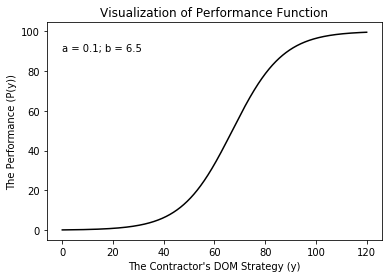

In [13]:
visualPerfFunc(a, b)

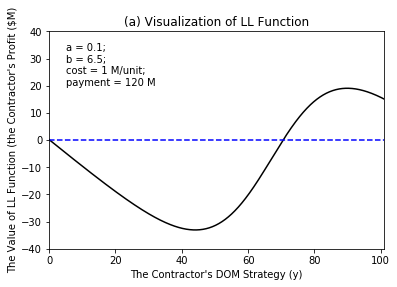

In [14]:
visualLLFunc(120, a, b, 1, 1)

no feasible solution
no feasible solution
no feasible solution
no feasible solution
no feasible solution
no feasible solution
no feasible solution


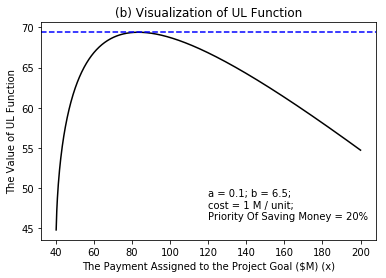

In [15]:
visualULFunc(0.1, 1, 1, 1, 0.2)

## Results from the case input 

In [20]:
# function to calculate the result
result = multipleGeneration(generation, sizePopulation, numPay, lowBoundPay, upBoundPay,
                       prior, finPrior, cost, maxDeduct, budget, numBestSample, numLuckSample,
                       mutationProb, negRange, posRange, a, b, MIRR)

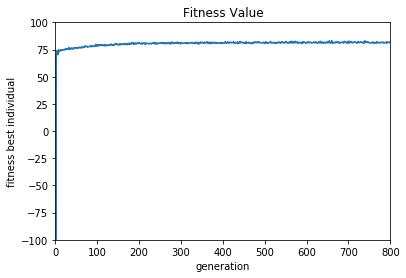

In [21]:
# fitness value
evolutionBestFitness(result)

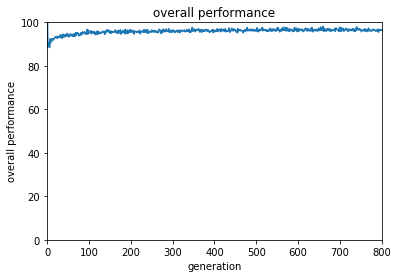

In [22]:
# overall performance
evolutionBestPerf(result)

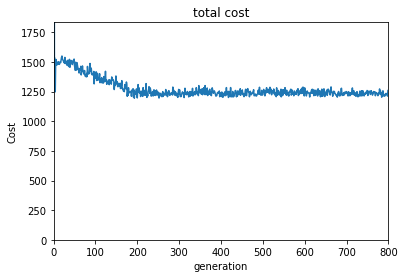

In [23]:
# total project payment
evolutionTotalCost(result, budget)

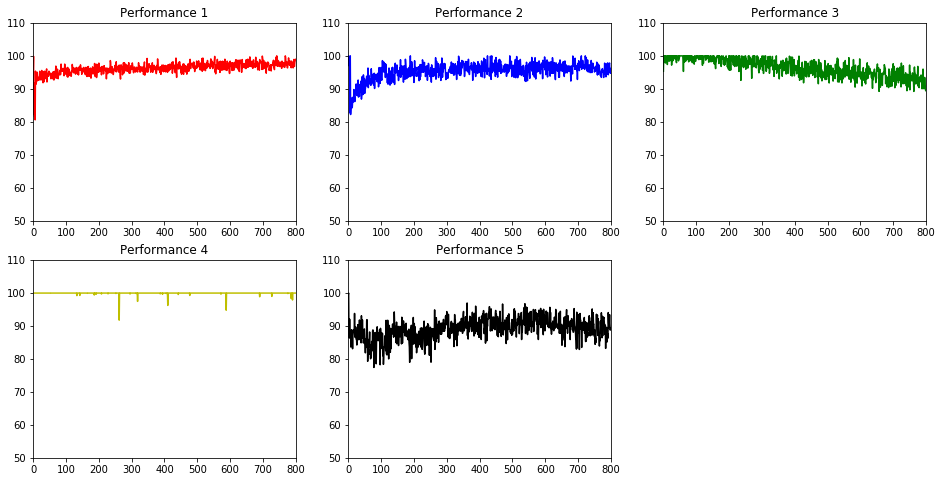

In [24]:
# each performance 
eachPerf = getEachPerf(result)
evolutionPerf(result, eachPerf)

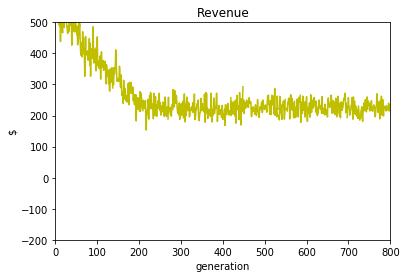

In [25]:
# contractor's revenue
evolutionRevenue(result, numPay, a, b, cost, maxDeduct)

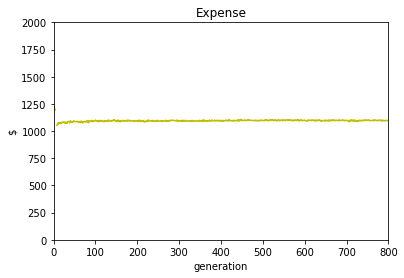

In [26]:
# contractor's expense
evolutionExpense(result, numPay, a, b, cost, maxDeduct)

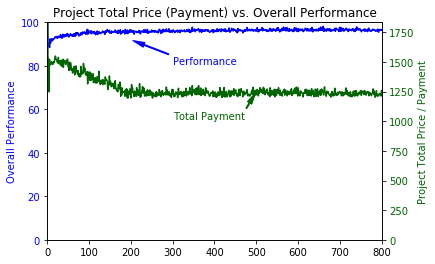

In [27]:
# Project total payment vs. overall performance
evolutionPriceCost(result, budget)

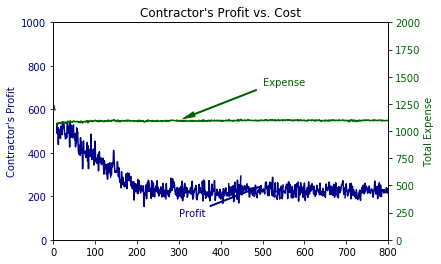

In [28]:
# Contractor's overall profit vs. cost
evolutionProfitExpense(result, numPay, a, b, cost, maxDeduct)

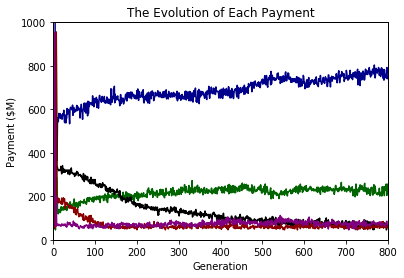

In [29]:
# Evolution of each payment
evolutionEachPayment(result)

<Figure size 576x288 with 0 Axes>

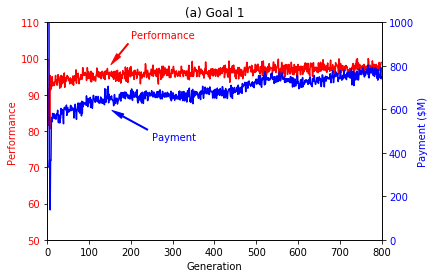

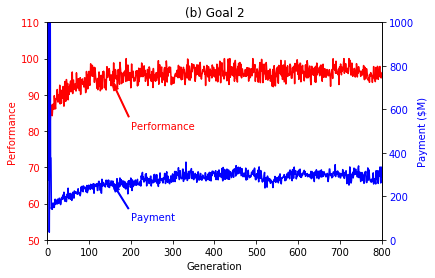

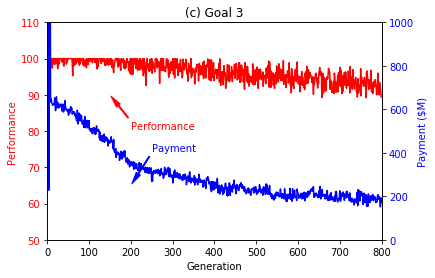

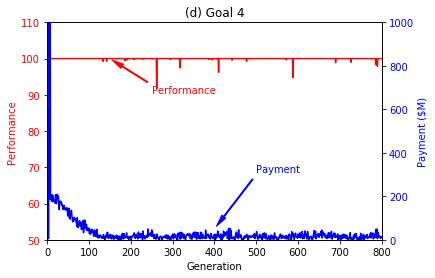

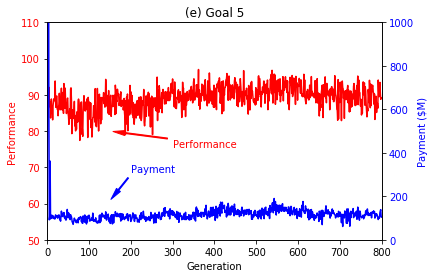

In [30]:
# Payment vs. Performance for each project goal
eachPerf = getEachPerf(result)
evolutionEachPerfPay(result, eachPerf)

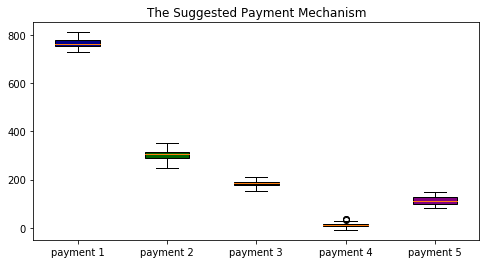

In [31]:
# The suggested payment mechanism
visualPayment(result)